# 3D dataset

## Data generation

In [1]:
import numpy as np
import pandas as pd
from anndata import AnnData

# Generate spatial coordinates (square grid, 3 regions with 4 cells each)
coords = []
for region in ['test1', 'test2', 'test3']:
    # Generate 2x2 grid coordinates for each region (e.g., test1 near (0,0), test2 near (2,0), test3 near (0,2))
    x = [0, 1, 0, 1] if region == 'test1' else [2, 3, 2.5] if region == 'test2' else [0, 1, 2, 3]
    y = [0, 0, 1, 1] if region == 'test1' else [0, 0, 1] if region == 'test2' else [2, 2, 3, 3]
    coords.extend(list(zip(x, y)))

# Generate observation data (obs)
obs = pd.DataFrame({
    'X': [c[0] for c in coords],
    'Y': [c[1] for c in coords],
    'Region': ['test1']*4 + ['test2']*3 + ['test3']*4
})

# Generate feature data (var), example with 5 genes
var = pd.DataFrame(index=[f'Gene_{i}' for i in range(5)])

# Recommend some papers on gene data analysis. Generate an expression matrix (random normal distribution data)
X = np.random.normal(size=(11, 5))  # 12 cells × 5 genes

adata = AnnData(X=X, obs=obs, var=var)

adata.obsm['spatial'] = np.array(coords)

adata.uns['Region_colors'] = ['#1f77b4', '#ff7f0e', '#2ca02c']
adata.uns['label_color'] = '#000000'

# Verify the structure (Requirements: 12 cells × 5 genes)
print(adata)

AnnData object with n_obs × n_vars = 11 × 5
    obs: 'X', 'Y', 'Region'
    uns: 'Region_colors', 'label_color'
    obsm: 'spatial'


/mnt/mydisk/home/chenxd/.conda/envs/STAGATE/lib/python3.9/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


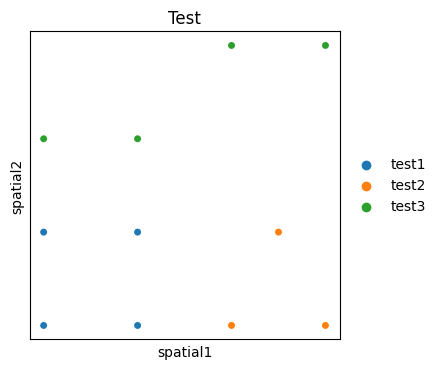

In [2]:
import matplotlib.pyplot as plt
import scanpy as sc
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.embedding(adata, basis="spatial", color=['Region'], s=100,title='Test')

In [3]:
adata1 = adata.copy()
adata2 = adata.copy()
adata3 = adata.copy()
adata_list = [adata1, adata2, adata3]
# Add Z-coordinate to each dataset
z_coords = [0, 2, 4]
for i, ad in enumerate(adata_list):
    ad.obs['Z'] = np.full(ad.n_obs, z_coords[i])

# Merge three datasets
combined_adata = adata_list[0].concatenate(adata_list[1:])

# Define slice ID
section_ids = ['Slice1', 'Slice2', 'Slice3']
section_id_list = []
for i, ad in enumerate(adata_list):
    section_id_list.extend([section_ids[i]] * ad.n_obs)

# Add a Section_id column to the merged dataset
combined_adata.obs['Section_id'] = section_id_list
adata = combined_adata
adata


/tmp/ipykernel_1688022/772422936.py:11: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  combined_adata = adata_list[0].concatenate(adata_list[1:])


AnnData object with n_obs × n_vars = 33 × 5
    obs: 'X', 'Y', 'Region', 'Z', 'batch', 'Section_id'
    obsm: 'spatial'

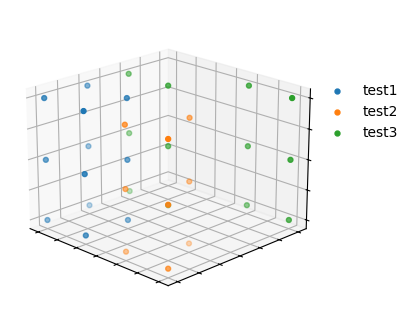

In [4]:
fig = plt.figure(figsize=(4, 4))
ax1 = plt.axes(projection='3d')
adata.uns['mclust_colors'] = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
for it, label in enumerate(np.unique(adata.obs['Region'])):
    temp_Coor = adata.obs.loc[adata.obs['Region']==label, :]
    temp_xd = temp_Coor['X']
    temp_yd = temp_Coor['Y']
    temp_zd = temp_Coor['Z']
    ax1.scatter3D(temp_xd, temp_yd, temp_zd, c=adata.uns['mclust_colors'][it],s=50, marker=".", label=label)

ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_zlabel('')

ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_zticklabels([])

plt.legend(bbox_to_anchor=(1.3,0.8), markerscale=1, frameon=False)
# plt.title('Region-3D')

ax1.elev = 20 #45
ax1.azim = -45 #-20

plt.show()

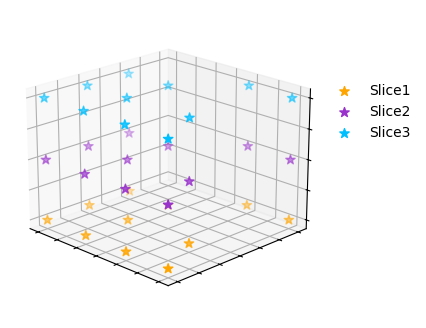

In [5]:
import numpy as np
import matplotlib.pyplot as plt

section_colors = ['#FFA500', '#9932CC', '#00BFFF']
symbols = ['*', '*', '*']

fig = plt.figure(figsize=(4, 4))
ax1 = plt.axes(projection='3d')
legend_order = ["Slice1", "Slice2", "Slice3"]

# Plot a scatter plot in the order of the legend
for label in legend_order:
    if label in np.unique(adata.obs['Section_id']):
        temp_Coor = adata.obs.loc[adata.obs['Section_id'] == label, :]
        temp_xd = temp_Coor['X']
        temp_yd = temp_Coor['Y']
        temp_zd = temp_Coor['Z']
        index = legend_order.index(label)
        ax1.scatter3D(temp_xd, temp_yd, temp_zd, c=section_colors[index], s=50, marker=symbols[index], label=label)

ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_zlabel('')

ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_zticklabels([])

plt.legend(bbox_to_anchor=(1, 0.8), markerscale=1, frameon=False)

ax1.elev = 20  # 45
ax1.azim = -45  # -20

plt.show()


## calculate_iou_3d

In [ ]:
import numpy as np
from scipy.spatial import ConvexHull
import trimesh
from scipy.optimize import linear_sum_assignment

def calculate_iou_3d(adata, label_column='mclust', num=4):
    # Check data integrity
    if 'spatial' not in adata.obsm or 'Region' not in adata.obs or label_column not in adata.obs:
        print("The data is incomplete, please check. adata.obsm['spatial'] and adata.obs columns.")
        return 0

    # Get all regional categories
    regions = adata.obs['Region'].unique()
    pred_labels = adata.obs[label_column].unique()

    # Build a cost matrix
    cost_matrix = np.zeros((len(regions), len(pred_labels)))
    for i, region in enumerate(regions):
        for j, pred_label in enumerate(pred_labels):
            region_mask = adata.obs['Region'] == region
            pred_mask = adata.obs[label_column] == pred_label
            match_count = np.sum(region_mask & pred_mask)
            cost_matrix[i, j] = -match_count  # Maximize the number of matches, so take the negative value

    # Use the Hungarian algorithm for matching
    row_indices, col_indices = linear_sum_assignment(cost_matrix)

    # Establish regional correspondence
    region_mapping = {}
    for i, j in zip(row_indices, col_indices):
        region = regions[i]
        pred_label = pred_labels[j]
        region_mapping[region] = pred_label

    # Print the corresponding relationship between the original region and the predicted region
    print("The corresponding relationship between the original region and the predicted region:")
    for region, pred_label in region_mapping.items():
        print(f"Original region: {region} -> Predicted region: {pred_label}")

    total_cells = len(adata)
    weighted_iou_sum = 0
    iou_dict = {}
    
    for region in regions:
        region_mask = adata.obs['Region'] == region
        origin_indices = np.where(region_mask)[0]
        origin_coords = adata.obsm['spatial'][origin_indices]

        # Get the corresponding predicted region
        pred_label = region_mapping[region]
        pred_mask = adata.obs[label_column] == pred_label
        pred_coords = adata.obsm['spatial'][pred_mask]

        # Generate 3D convex hull
        def get_volume(points):
            if len(points) >= num:
                try:
                    volume = trimesh.convex.convex_hull(points).volume
                    return volume
                except Exception as e:
                    print(f"Failed to generate the convex hull, area: {region}, error message: {e}")
                    return 0.0
            return 0.0

        origin_vol = get_volume(origin_coords)
        pred_vol = get_volume(pred_coords)

        # Print the intermediate results, keeping two decimal places.
        print(f"Region: {region}, Original volume: {origin_vol:.2f}, Predict volume: {pred_vol:.2f}")

        # Calculate the intersection volume
        intersection = 0.0
        if origin_vol > 0 and pred_vol > 0:
            try:
                hull1 = trimesh.convex.convex_hull(origin_coords)
                hull2 = trimesh.convex.convex_hull(pred_coords)
                intersection = hull1.intersection(hull2).volume
            except Exception as e:
                print(f"Failed to calculate the intersection volume, area: {region}, error message: {e}")

        # Calculate the union and IoU
        union = origin_vol + pred_vol - intersection
        iou = intersection / union if union > 0 else 0.0
        iou_dict[region] = iou
        # Print the IoU for each region, keeping two decimal places
        print(f"Region: {region}, IoU: {iou:.2f}")

        # weighted sum
        weighted_iou_sum += (len(origin_indices) / total_cells) * iou

    return "{:.3f}".format(weighted_iou_sum), region_mapping, iou_dict


In [7]:
adata.obsm['spatial'] = adata.obs.loc[:, ['X', 'Y','Z']].values
calculate_iou_3d(adata, label_column='Region', num=2)

The corresponding relationship between the original region and the predicted region:
Original region: test1 -> Predicted region: test1
Original region: test2 -> Predicted region: test2
Original region: test3 -> Predicted region: test3
domain: test1, Original volume: 4.00, Predict volume: 4.00
Region: test1, IoU: 1.00
domain: test2, Original volume: 2.00, Predict volume: 2.00
Region: test2, IoU: 1.00
domain: test3, Original volume: 4.00, Predict volume: 4.00
Region: test3, IoU: 1.00


('1.000',
 {'test1': 'test1', 'test2': 'test2', 'test3': 'test3'},
 {'test1': 1.0, 'test2': 1.0, 'test3': 1.0})

## plot_region_boundaries_3d

In [8]:
import numpy as np
from scipy.spatial import ConvexHull
import trimesh
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def plot_region_boundaries_3d(adata, label_column='mclust', invert_y=False, num=4):
    # Call the calculate_iou_3d function to obtain the corresponding relationships and IoU values
    _, region_mapping, iou_dict = calculate_iou_3d(adata, label_column, num)

    # Get the predicted labels and original labels
    pred_labels = adata.obs[label_column].astype(str)
    origin_labels = adata.obs['Region'].astype(str)

    # Get unique labels and sort them
    unique_pred = np.unique(pred_labels)
    unique_origin = np.unique(origin_labels)

    # Determine the number of rows for subplots (based on predicted clusters)
    n = len(unique_pred)
    fig, axes = plt.subplots(n, 1, figsize=(6, 6 * n), subplot_kw={'projection': '3d'})

    # Handle the case of a single row
    if n == 1:
        axes = [axes]

    # Extract spatial coordinates
    spatial_coords = adata.obsm['spatial']

    def plot_single_cluster(ax, cluster_id, labels, color):
        # Get the coordinates corresponding to the current cluster
        mask = labels == cluster_id
        cluster_coords = spatial_coords[mask]

        if len(cluster_coords) < num:
            return

        try:
            # Draw the convex hull
            hull = ConvexHull(cluster_coords)
            triangles = cluster_coords[hull.simplices]
            poly = Poly3DCollection(
                triangles,
                alpha=0.2,
                facecolor=color,
                edgecolor='#404040',
                linestyle='--',
                linewidths=0.8
            )
            ax.add_collection3d(poly)
        except Exception as e:
            print(f"Failed to draw the convex hull for cluster {cluster_id}: {e}")

        # Unified coordinate axis settings
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        if invert_y:
            ax.invert_yaxis()
        ax.view_init(elev=30, azim=45)

    # Draw each cluster
    for row, pred_id in enumerate(unique_pred):
        # Get the corresponding original cluster ID
        origin_id = None
        for key, value in region_mapping.items():
            if str(value) == str(pred_id):
                origin_id = str(key)
                break

        # Draw the original clusters
        if origin_id is not None:
            plot_single_cluster(axes[row], origin_id, origin_labels, color='lightgreen')

        # Draw predictive clustering
        plot_single_cluster(axes[row], pred_id, pred_labels, color='lightblue')

        # Set the subplot title as the corresponding relationship and IoU value
        if origin_id in iou_dict:
            axes[row].set_title(f'Origin: {origin_id} -> Pred: {pred_id}, IoU: {iou_dict[origin_id]:.2f}')

    # Add legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='lightgreen', lw=4, label='Origin'),
        Line2D([0], [0], color='lightblue', lw=4, label='Pred')
    ]
    fig.legend(handles=legend_elements, loc='upper right')

    plt.tight_layout()
    plt.show()

The corresponding relationship between the original region and the predicted region:
Original region: test1 -> Predicted region: test1
Original region: test2 -> Predicted region: test2
Original region: test3 -> Predicted region: test3
domain: test1, Original volume: 4.00, Predict volume: 4.00
Region: test1, IoU: 1.00
domain: test2, Original volume: 2.00, Predict volume: 2.00
Region: test2, IoU: 1.00
domain: test3, Original volume: 4.00, Predict volume: 4.00
Region: test3, IoU: 1.00


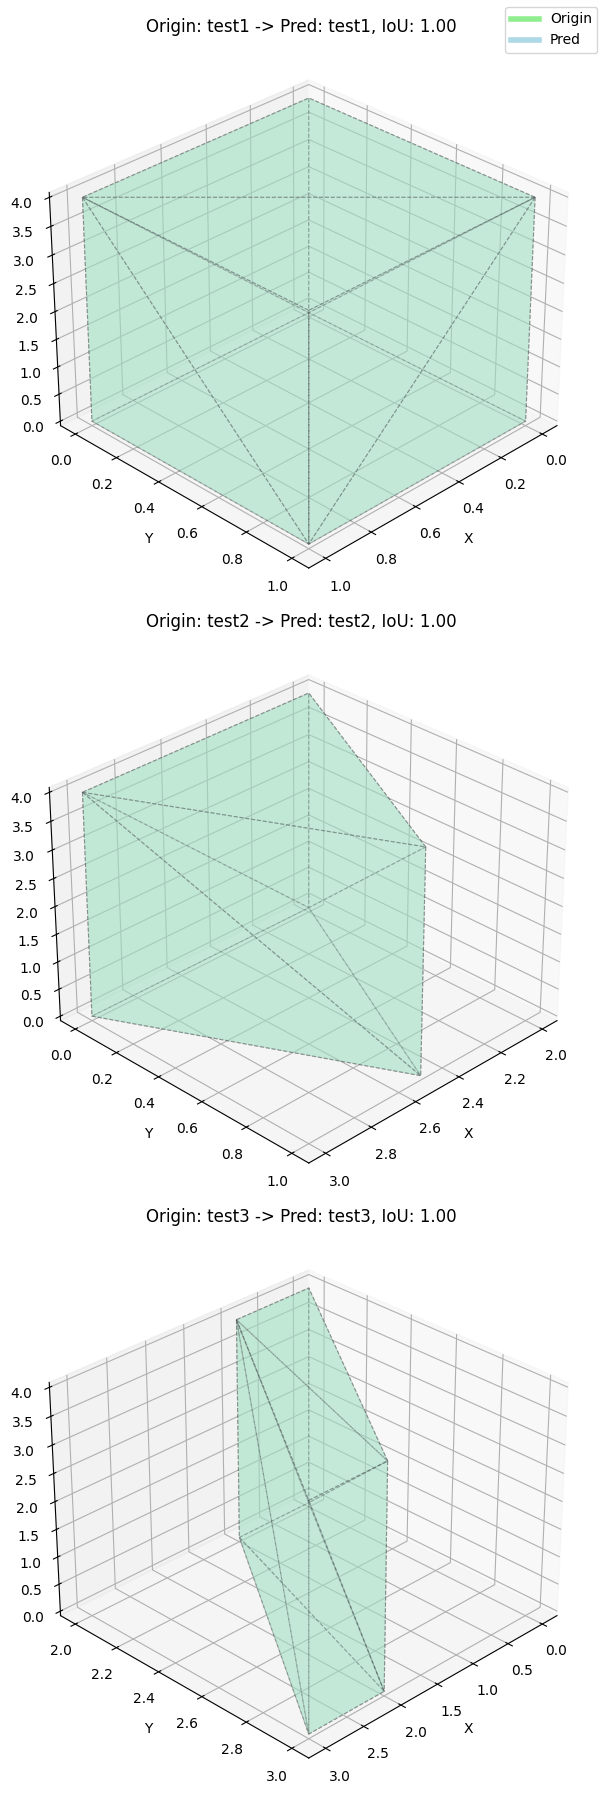

In [9]:
plot_region_boundaries_3d(adata, label_column='Region', invert_y=False, num=4) # mclust

In [10]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import FlatST
import STAGATE_pyG
import os

## Run_FlatST

In [11]:
adata1 = sc.read_h5ad('/mnt/mydisk/home/chenxd/lwfx/data/4_STARmap/2_STARmap_mouse_PFC/Mouse Prefrontal Cortex_BZ5.h5ad')
adata2 = sc.read_h5ad('/mnt/mydisk/home/chenxd/lwfx/data/4_STARmap/2_STARmap_mouse_PFC/Mouse Prefrontal Cortex_BZ9.h5ad')
adata3 = sc.read_h5ad('/mnt/mydisk/home/chenxd/lwfx/data/4_STARmap/2_STARmap_mouse_PFC/Mouse Prefrontal Cortex_BZ14.h5ad')
adata1

AnnData object with n_obs × n_vars = 1049 × 166
    obs: 'X', 'Y', 'Region'
    uns: 'label_color'
    obsm: 'spatial'

In [12]:
adata_list = [adata1, adata2, adata3]
z_coords = [0, 20, 40]
for i, ad in enumerate(adata_list):
    ad.obs['Z'] = np.full(ad.n_obs, z_coords[i])

combined_adata = adata_list[0].concatenate(adata_list[1:])

section_ids = ['BZ5', 'BZ9', 'BZ14']
section_id_list = []
for i, ad in enumerate(adata_list):
    section_id_list.extend([section_ids[i]] * ad.n_obs)

# Add the Section_id column to the merged dataset
combined_adata.obs['Section_id'] = section_id_list
adata = combined_adata
adata

/tmp/ipykernel_1688022/1550288511.py:6: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  combined_adata = adata_list[0].concatenate(adata_list[1:])


AnnData object with n_obs × n_vars = 3190 × 166
    obs: 'X', 'Y', 'Region', 'Z', 'batch', 'Section_id'
    obsm: 'spatial'

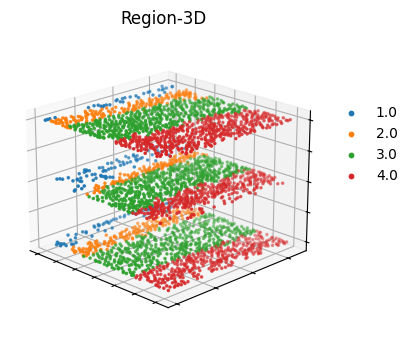

In [13]:
fig = plt.figure(figsize=(4, 4))
ax1 = plt.axes(projection='3d')
adata.uns['mclust_colors'] = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
for it, label in enumerate(np.unique(adata.obs['Region'])):
    temp_Coor = adata.obs.loc[adata.obs['Region']==label, :]
    temp_xd = temp_Coor['X']
    temp_yd = temp_Coor['Y']
    temp_zd = temp_Coor['Z']
    ax1.scatter3D(temp_xd, temp_yd, temp_zd, c=adata.uns['mclust_colors'][it],s=10, marker=".", label=label)

ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_zlabel('')

ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_zticklabels([])

plt.legend(bbox_to_anchor=(1.3,0.8), markerscale=2, frameon=False)
plt.title('Region-3D')

ax1.elev = 20 #45
ax1.azim = -45 #-20

plt.show()

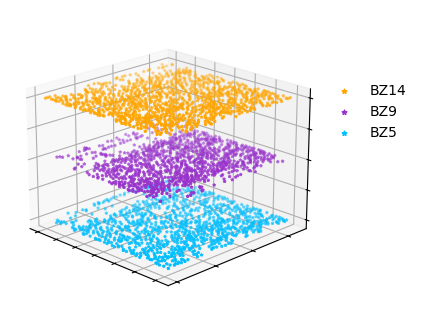

In [14]:
import numpy as np
import matplotlib.pyplot as plt

section_colors = ['#FFA500', '#9932CC', '#00BFFF']
symbols = ['*', '*', '*']
fig = plt.figure(figsize=(4, 4))
ax1 = plt.axes(projection='3d')
legend_order = ["BZ14", "BZ9", "BZ5"]
for label in legend_order:
    if label in np.unique(adata.obs['Section_id']):
        temp_Coor = adata.obs.loc[adata.obs['Section_id'] == label, :]
        temp_xd = temp_Coor['X']
        temp_yd = temp_Coor['Y']
        temp_zd = temp_Coor['Z']
        index = legend_order.index(label)
        ax1.scatter3D(temp_xd, temp_yd, temp_zd, c=section_colors[index], s=3, marker=symbols[index], label=label)

ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_zlabel('')

ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_zticklabels([])

plt.legend(bbox_to_anchor=(1, 0.8), markerscale=2, frameon=False)

ax1.elev = 20  # 45
ax1.azim = -45  # -20

plt.show()


In [15]:
# Normalization
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [16]:
section_order = ['BZ5', 'BZ9', 'BZ14']
FlatST.Cal_Spatial_Net_3D(adata, rad_cutoff_2D=500, rad_cutoff_Zaxis=500,
                           key_section='Section_id', section_order = section_order, verbose=True)

Radius used for 2D SNN: 500
Radius used for SNN between sections: 500
------Calculating 2D SNN of section  BZ14
This graph contains 11500 edges, 1088 cells.
10.5699 neighbors per cell on average.
------Calculating 2D SNN of section  BZ5


/mnt/mydisk/home/chenxd/.conda/envs/STAGATE/lib/python3.9/site-packages/FlatST-1.0.1-py3.9.egg/FlatST/utils.py:530: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['Spatial_Net'] = Spatial_Net
/mnt/mydisk/home/chenxd/.conda/envs/STAGATE/lib/python3.9/site-packages/FlatST-1.0.1-py3.9.egg/FlatST/utils.py:530: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['Spatial_Net'] = Spatial_Net


This graph contains 10812 edges, 1049 cells.
10.3070 neighbors per cell on average.
------Calculating 2D SNN of section  BZ9


/mnt/mydisk/home/chenxd/.conda/envs/STAGATE/lib/python3.9/site-packages/FlatST-1.0.1-py3.9.egg/FlatST/utils.py:530: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['Spatial_Net'] = Spatial_Net


This graph contains 12578 edges, 1053 cells.
11.9449 neighbors per cell on average.
------Calculating SNN between adjacent section BZ5 and BZ9.


/mnt/mydisk/home/chenxd/.conda/envs/STAGATE/lib/python3.9/site-packages/FlatST-1.0.1-py3.9.egg/FlatST/utils.py:530: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['Spatial_Net'] = Spatial_Net


This graph contains 22162 edges, 2102 cells.
10.5433 neighbors per cell on average.
------Calculating SNN between adjacent section BZ9 and BZ14.


/mnt/mydisk/home/chenxd/.conda/envs/STAGATE/lib/python3.9/site-packages/FlatST-1.0.1-py3.9.egg/FlatST/utils.py:530: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['Spatial_Net'] = Spatial_Net


This graph contains 23358 edges, 2141 cells.
10.9099 neighbors per cell on average.
3D SNN contains 80410 edges, 3190 cells.
25.2069 neighbors per cell on average.


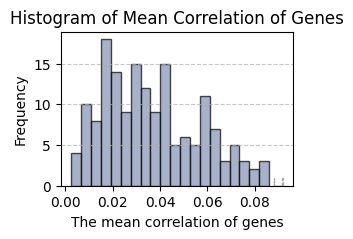

Size of Input:  (3190, 164)


100%|██████████| 1300/1300 [00:15<00:00, 83.28it/s]


In [17]:
adata = FlatST.train_FlatST(adata)

In [18]:
os.environ['R_HOME'] = '/mnt/mydisk/home/chenxd/.conda/envs/r_env/lib/R'
num_cluster = 4
adata = FlatST.mclust_R(adata, num_cluster, used_obsm='FlatST')

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


In [19]:
sc.pp.neighbors(adata, use_rep='FlatST')
sc.tl.umap(adata)

/mnt/mydisk/home/chenxd/.conda/envs/STAGATE/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


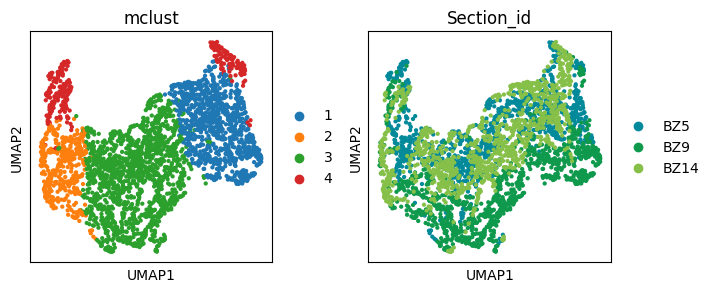

In [20]:
adata.uns['Section_id_colors'] = ['#02899A', '#0E994D', '#86C049', '#FBB21F', '#F48022', '#DA5326', '#BA3326']
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata, color=['mclust', 'Section_id'])

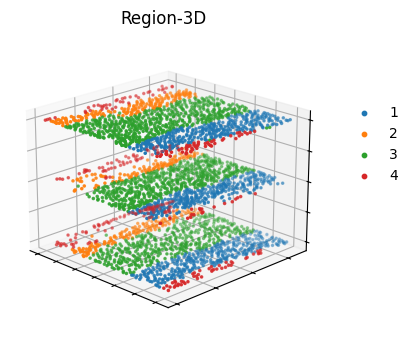

In [21]:
fig = plt.figure(figsize=(4, 4))
ax1 = plt.axes(projection='3d')
adata.uns['mclust_colors'] = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
for it, label in enumerate(np.unique(adata.obs['mclust'])):
    temp_Coor = adata.obs.loc[adata.obs['mclust']==label, :]
    temp_xd = temp_Coor['X']
    temp_yd = temp_Coor['Y']
    temp_zd = temp_Coor['Z']
    ax1.scatter3D(temp_xd, temp_yd, temp_zd, c=adata.uns['mclust_colors'][it],s=10, marker=".", label=label)

ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_zlabel('')

ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_zticklabels([])

plt.legend(bbox_to_anchor=(1.3,0.8), markerscale=2, frameon=False)
plt.title('Region-3D')

ax1.elev = 20 #45
ax1.azim = -45 #-20

plt.show()

In [22]:
adata.obsm['spatial'] = adata.obs.loc[:, ['X', 'Y','Z']].values
calculate_iou_3d(adata, label_column='mclust', num=4)

The corresponding relationship between the original region and the predicted region:
Original region: 1.0 -> Predicted region: 4
Original region: 2.0 -> Predicted region: 2
Original region: 3.0 -> Predicted region: 3
Original region: 4.0 -> Predicted region: 1
domain: 1.0, Original volume: 487106361.48, Predict volume: 2766314218.93
Region: 1.0, IoU: 0.18
domain: 2.0, Original volume: 688650929.94, Predict volume: 578911229.81
Region: 2.0, IoU: 0.79
domain: 3.0, Original volume: 1389656972.92, Predict volume: 1841860905.46
Region: 3.0, IoU: 0.75
domain: 4.0, Original volume: 1095417553.11, Predict volume: 849595421.29
Region: 4.0, IoU: 0.77


('0.723',
 {1.0: 4, 2.0: 2, 3.0: 3, 4.0: 1},
 {1.0: 0.1758593083020879,
  2.0: 0.7887724673330803,
  3.0: 0.7457371110880143,
  4.0: 0.7651678354882954})

The corresponding relationship between the original region and the predicted region:
Original region: 1.0 -> Predicted region: 4
Original region: 2.0 -> Predicted region: 2
Original region: 3.0 -> Predicted region: 3
Original region: 4.0 -> Predicted region: 1
domain: 1.0, Original volume: 487106361.48, Predict volume: 2766314218.93
Region: 1.0, IoU: 0.18
domain: 2.0, Original volume: 688650929.94, Predict volume: 578911229.81
Region: 2.0, IoU: 0.79
domain: 3.0, Original volume: 1389656972.92, Predict volume: 1841860905.46
Region: 3.0, IoU: 0.75
domain: 4.0, Original volume: 1095417553.11, Predict volume: 849595421.29
Region: 4.0, IoU: 0.77


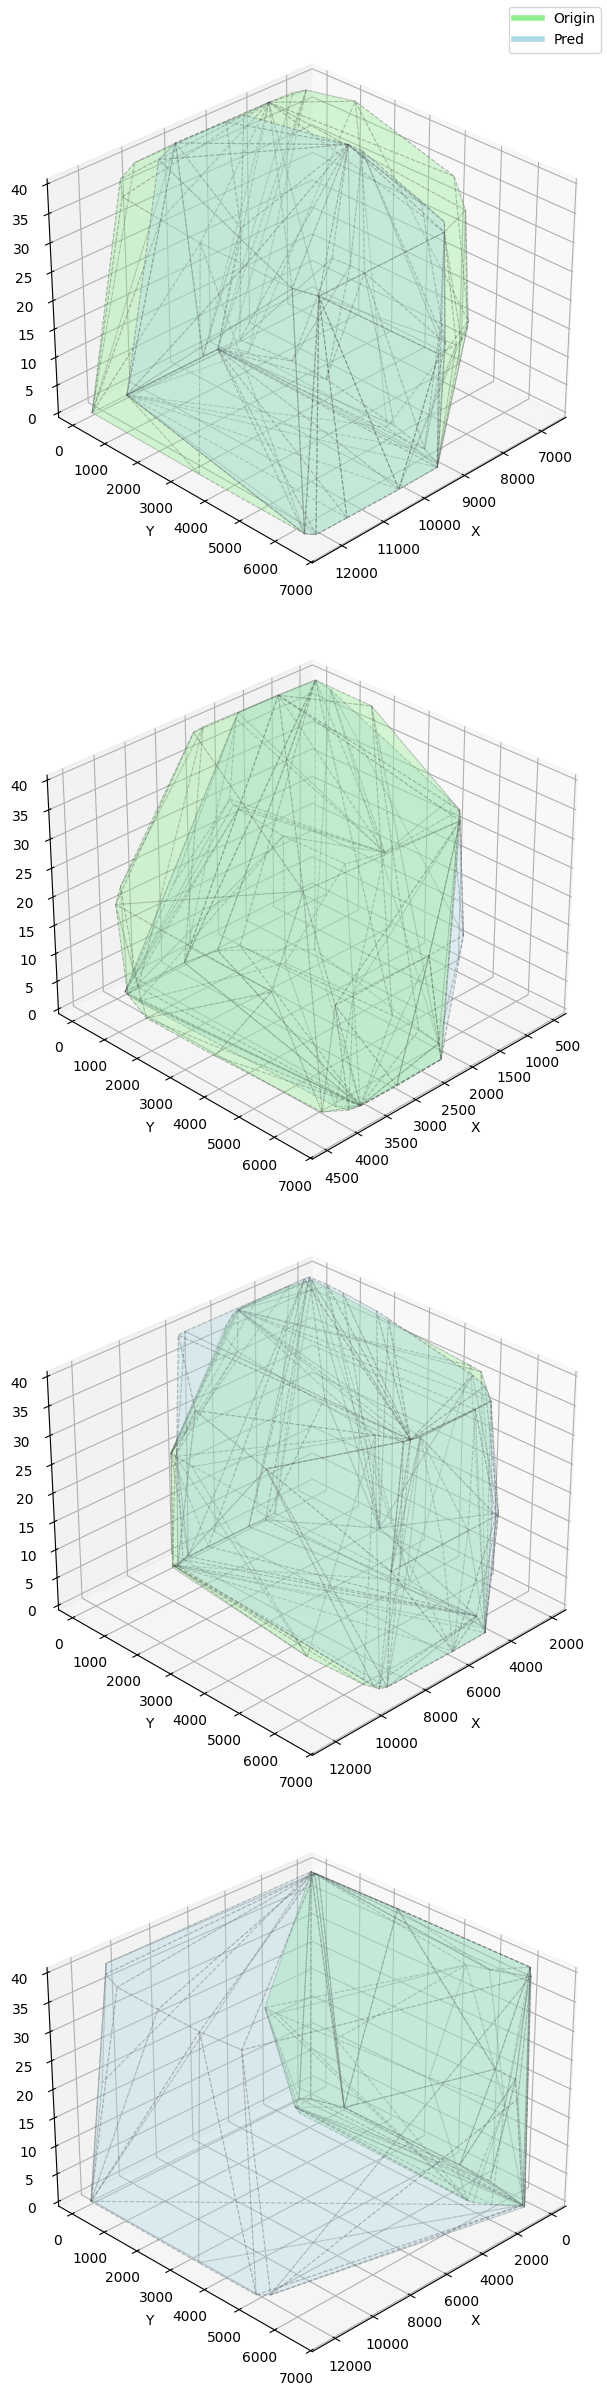

In [23]:
plot_region_boundaries_3d(adata, label_column='mclust', invert_y=False, num=4) # mclust